# Исследование закономерностей, определяющих популярность компьютерных игр

Интернет-магазин продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

## Открываем файл с данными и изучаем общую информацию

In [43]:
# импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats as st

import warnings
warnings.filterwarnings("ignore")

In [44]:
pd.set_option('display.max_columns', None)
data = pd.read_csv( '/datasets/games.csv')
# сохраняем размер изначальный размер данных
data_sh = data.shape[0]
data.head(10)


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [46]:
print('Количество дубликатов в данных', data.duplicated().sum())

Количество дубликатов в данных 0


array([[<AxesSubplot:title={'center':'Year_of_Release'}>,
        <AxesSubplot:title={'center':'NA_sales'}>],
       [<AxesSubplot:title={'center':'EU_sales'}>,
        <AxesSubplot:title={'center':'JP_sales'}>],
       [<AxesSubplot:title={'center':'Other_sales'}>,
        <AxesSubplot:title={'center':'Critic_Score'}>]], dtype=object)

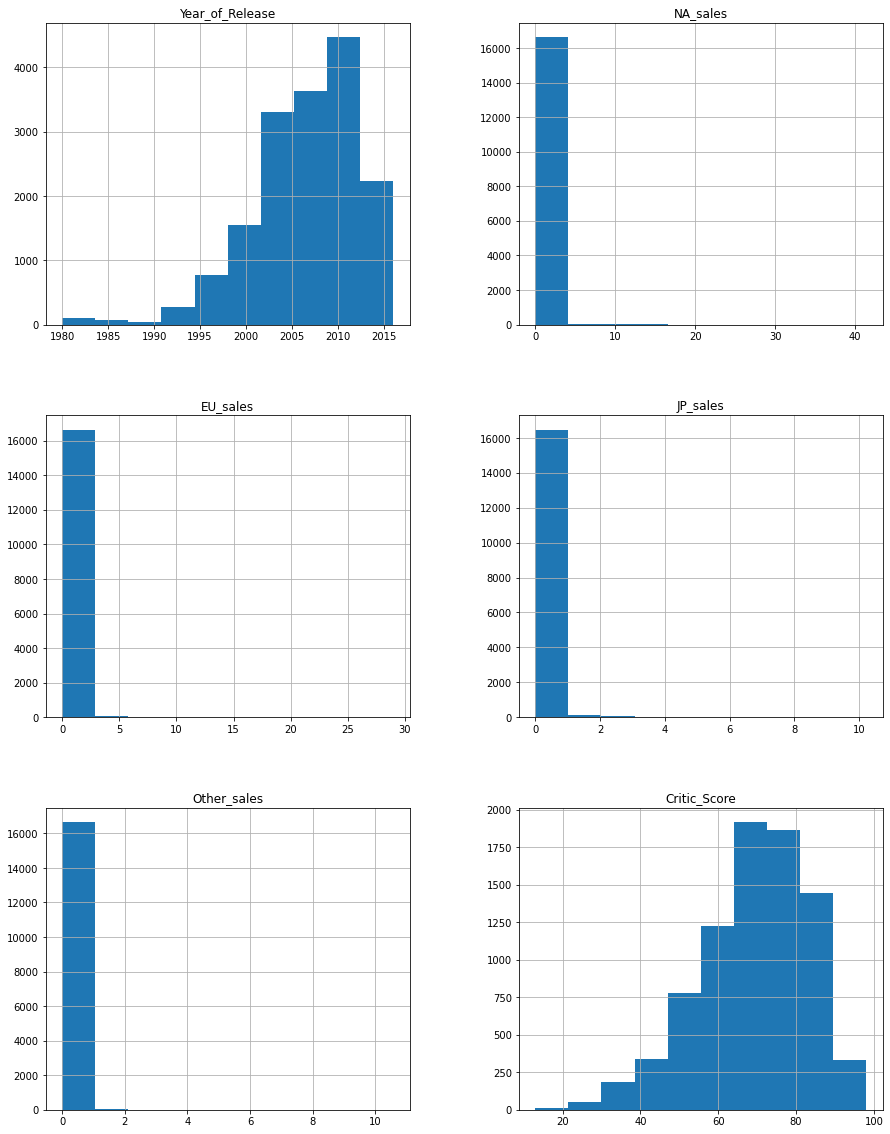

In [47]:
data.hist(figsize=(15, 20))

### Итоги ознакомления с данными

 - Тип данных стоблца `Year_of_Release` - float, нужно заменить на int.
 - Тип данных столбца `User_Score` - object, нужно заменить на float.
 - Тип данных столбца `Critic_Score` - float, нужно заменить на int.
 - Видно, что больше всего пропусков в столбцах `Critic_Score,  User_Score, Rating`.
 - Явных дубликатов в данных нет.
 - Данные о продажах имеют явные выбросы из общей статистики.


## Подгодотвка данных

###  Приводим названия столбцов к нижнему регистру

In [48]:
data.columns = data.columns.str.lower()


### Обрабатываем пропущенные значения и приводим столбцы к нужному типу

In [49]:
# выводим количество пропущенных значений каждого стобца
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

- Пропущенных значений стобца `year_of_release` не так много (1.6 % количества строк датасета), их можно просто удалить.
- Также как и 2 пропуска в столбцах `name`,`genre`
- Столбцы `critic_score, user_score, rating`, наоброт, имеют большое количество пропусков, их просто удалить нельзя.

#### Обработка столбцов `year_of_release`, `name`, `genre`

In [50]:
# удаляем строки с пропусками в столбцах year_of_release, name, genre
data = data.dropna(subset=['year_of_release', 'name', 'genre']) 
# год выпуска должен иметь целочисленный тип
data['year_of_release'] = data['year_of_release'].astype('int')

#### Обработка столбца `user_score`

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       9839 non-null   object 
 10  rating           9768 non-null   object 
dtypes: float64(5), int64(1), object(5)
memory usage: 1.5+ MB


In [53]:
# много значений tbd - to be determined, в 'user_score'. 
# заменим их на NaN

data.loc[data['user_score']=='tbd','user_score'] = 'NaN'

#приводим user_score к типу данных float
data['user_score'] = data['user_score'].astype('float64')

#### Обработка столбца `rating`

In [54]:
# заменим NaN на 'unknown'
data['rating'] = data['rating'].fillna('unknown')

*Заменили NaN столбца `rating` на 'unknown', 
потому что пропущенных значений много и в анализе нужно отобразить, если rating будет неопределен*

### Суммарные продажи во всех регионах

In [55]:
# создаем новый столбец с суммарными продажами по регионам

data['all_sales'] = data[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)

### Итоги предобработки данных

 - привели названия столбцов к нижнему регистру
 - там, где пропусков мало: `year_of_release`, `name`, `genre` удалили данные
 - заменили `year_of_release` на целочисленный тип данных, `user_score` к типу float
 - значение tbd столбца `user_score` заменили на NaN
 - NaN в столбце `rating` заменили на 'unknown'

In [56]:
print('Количество сохраненных данных:',data.shape[0] / data_sh*100, '%')

Количество сохраненных данных: 98.37870176488184 %


## Исследовательский анализ данных

### Количество выпускаемых игр в разные годы

<AxesSubplot:title={'center':'Количество выпускаемых игр в разные годы'}, xlabel='Год релиза', ylabel='Количнство выпущенных игр'>

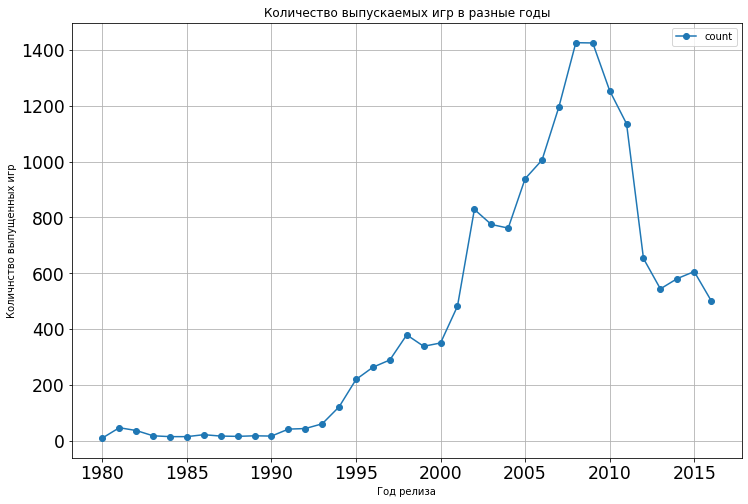

In [57]:
data.groupby('year_of_release').agg(count=('name', 'count'))\
.plot(kind = 'line', title = 'Количество выпускаемых игр в разные годы', figsize = (12,8),\
     style = 'o-',grid = True, xlabel = 'Год релиза', ylabel = 'Количнство выпущенных игр',\
      fontsize = 'xx-large') 

*Меньше всего игр было с 1994-2000, после восходящий тренд, больше всего игр выпустилось в 2008-2009 годах, после количество выпускаемых игр идет на спад*


 ### Динамика продаж по платформам

In [58]:
# сгруппируем данные по платформам, найдем среднее количество суммарных продаж, выберем 10 лучших
data_grouped = data.groupby(['platform'])\
.agg(sales=('all_sales', 'sum'))\
.sort_values(by = 'sales', ascending = False)\
.head(10)

data_grouped

,sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


*Больше всего продаж на платформах PS2, X360, PS3, Wii и DS*

<AxesSubplot:title={'center':'Динамика цен по годам. Топ 10 платформ'}, xlabel='Год релиза', ylabel='Суммарные продажи'>

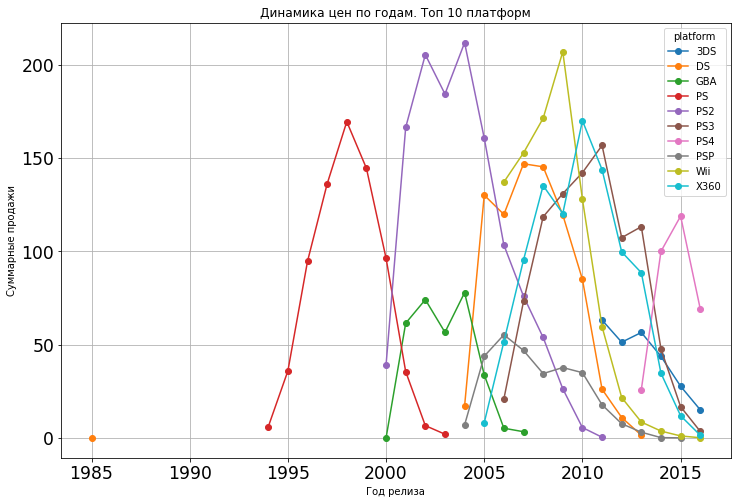

In [59]:
top_platform = data_grouped.index

# оставим данные по самым популярным платформам, сгруппируем по году и платформе, построим график

data.query('platform in @top_platform')\
.pivot_table(index = 'year_of_release', columns = 'platform', values = 'all_sales', aggfunc = 'sum')\
.plot(kind = 'line', title = 'Динамика цен по годам. Топ 10 платформ', figsize = (12,8),\
     style = 'o-',grid = True, xlabel = 'Год релиза', ylabel = 'Суммарные продажи',\
      fontsize = 'xx-large') 

- На платформе PS2 пик продаж достигался в 2004 году, после идёт резкий спад
- На платформе X360 пик продаж достигался в 2010 году, после идёт резкий спад
- На платформе Wii пик продаж достигался в 2009 году, а на платформе PS3 в 2011
- На платформе DS пик продаж достигался в 2007-2008 годах
- PS были популярны до 2000 года, после появилось PS2 и стала лидировать по продажам
- С 2006-2007 года PS2 обогнали Wii, DS, X360 и PS3
- C 2014 года самой популярной является PS4
- Характерный срок жизни платформ топ-10: 7-10 лет 
- Будем считать актуальными данные с 2014 года

In [60]:
data = data.query('year_of_release >= 2014')

In [61]:
data_grouped_last = data.groupby(['platform'])\
.agg(sales=('all_sales', 'sum'))\
.sort_values(by = 'sales', ascending = False)\
.head(10)

data_grouped_last

,sales
platform,
PS4,288.15
XOne,140.36
3DS,86.68
PS3,68.18
X360,48.22
WiiU,42.98
PC,27.05
PSV,22.40
Wii,5.07


<AxesSubplot:title={'center':'Динамика цен по годам. Топ 10 платформ за последние 3 года'}, xlabel='Год релиза', ylabel='Суммарные продажи'>

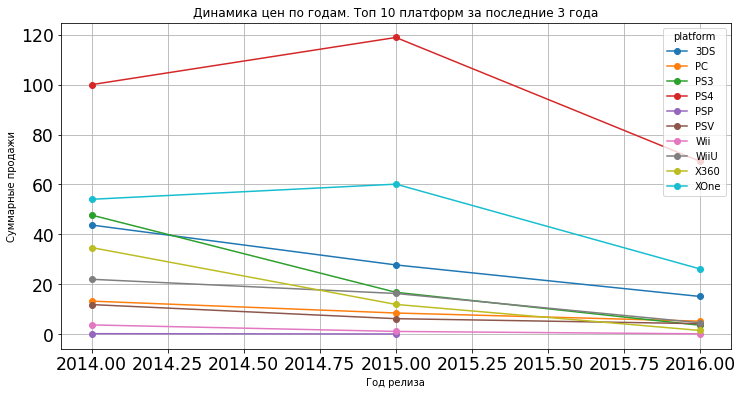

In [62]:
top_platform_last = data_grouped_last.index

# оставим данные по самым популярным платформам, сгруппируем по году и платформе, построим график

data.query('platform in @top_platform_last')\
.pivot_table(index = 'year_of_release', columns = 'platform', values = 'all_sales', aggfunc = 'sum')\
.plot(kind = 'line', title = 'Динамика цен по годам. Топ 10 платформ за последние 3 года', figsize = (12,6),\
     style = 'o-',grid = True, xlabel = 'Год релиза', ylabel = 'Суммарные продажи',\
      fontsize = 'xx-large') 

 *Потенциально прибылиные платформы: PS4 и XOne,
 они появились относительно недавно и являюся самыми популярными на 2016 год.
 При этом PS4 лидирут*

Text(0.5, 1.0, 'boxplot for the best')

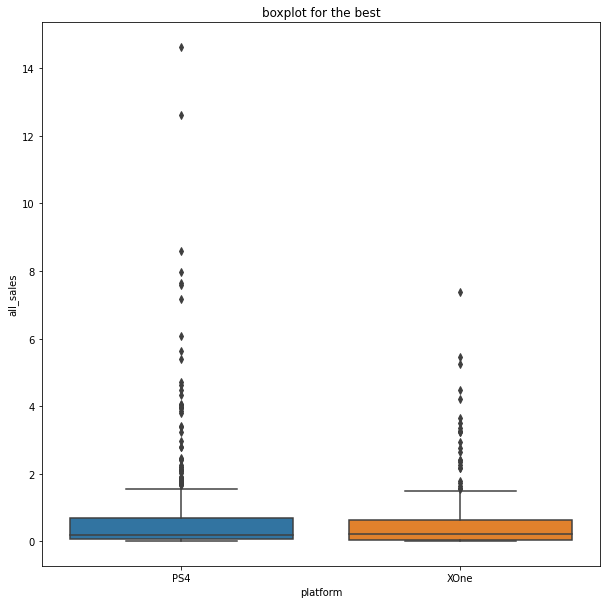

In [63]:
plt.figure(figsize=(10,10))
box = sns.boxplot(x="platform", y="all_sales", \
            data = data.query('platform == "PS4" or platform == "XOne"'))

box.set_title('boxplot for the best')


*Видно, что в данных по этим платформам есть большие выбросы, которые дают вклад в суммарные продажи. Построим данный график без выросов*

(-0.5, 1.5, 0.0, 1.6)

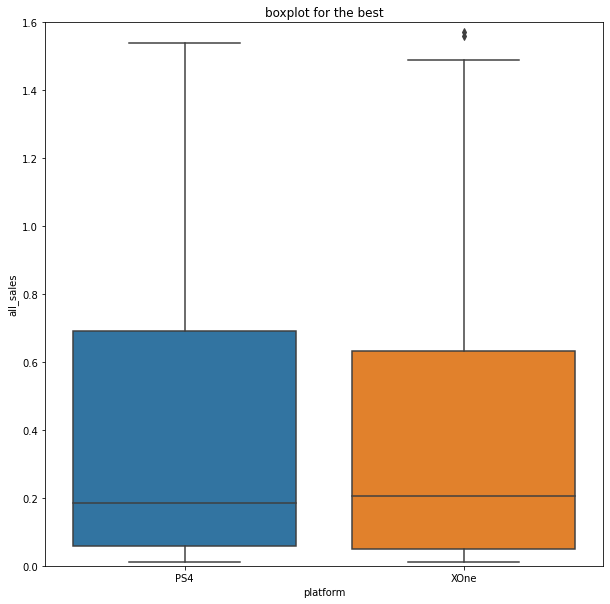

In [64]:
plt.figure(figsize=(10,10))
box = sns.boxplot(x="platform", y="all_sales", \
            data = data.query('platform == "PS4" or platform == "XOne"'))

box.set_title('boxplot for the best')
box.axis(ymin=0,ymax=1.6)


*Медианные значения примерно на одном уровне, также как и межквартильный размах*

### Влияние на продажи  отзывов пользователей и критиков.

Text(0.5, 1.0, 'Диаграмма рассеяния: оценки пользователей и суммарные продажи')

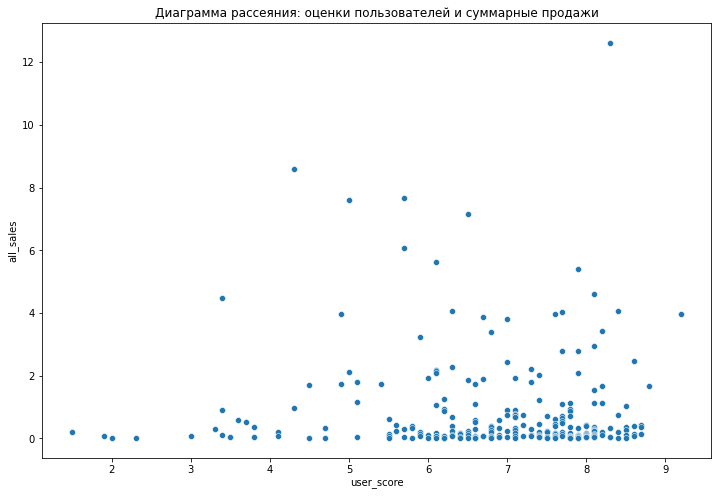

In [65]:
# рассмотрим одну популярную платформу: PS4
# построим диаграмму рессеяния оценки пользователей и суммарные продажи

plt.figure(figsize=(12,8))
diag = sns.scatterplot(x='user_score', y='all_sales', data = data.query('platform == "PS4"'))
diag.set_title('Диаграмма рассеяния: оценки пользователей и суммарные продажи')

In [66]:
#посчитаем коэффициент корреляции

print('Кэффициент корреляции между отзывами пользователей и суммарными продажами:', \
      data.query('platform == "PS4"')['user_score'].corr(data.query('platform == "PS4"')['all_sales']))

Кэффициент корреляции между отзывами пользователей и суммарными продажами: -0.040131589472697356


*По диаграмме рассеяния видно, что суммарные продажи всё же растут с оцеками пользователей, хоть и есть игры с низким рейтингом и высокими продажами. Коэффициент корреляции при этом низкий, но по графику видно, что связь не линейная.*

Text(0.5, 1.0, 'Диаграмма рассеяния: оценки критиков и суммарные продажи')

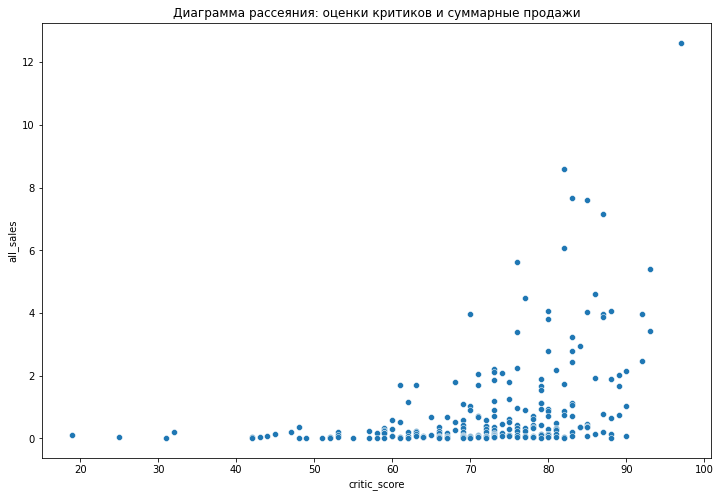

In [67]:
# рассмотрим одну популярную платформу: PS4
# построим диаграмму рессеяния оценки критиков и суммарные продажи

plt.figure(figsize=(12,8))
diag = sns.scatterplot(x='critic_score', y='all_sales', data = data.query('platform == "PS4"'))
diag.set_title('Диаграмма рассеяния: оценки критиков и суммарные продажи')

In [68]:
#посчитаем коэффициент корреляции

print('Кэффициент корреляции между отзывами критиков и суммарными продажами:', \
      data.query('platform == "PS4"')['critic_score'].corr(data.query('platform == "PS4"')['all_sales']))


Кэффициент корреляции между отзывами критиков и суммарными продажами: 0.40266141068104083


*По диаграмме рассеяния видно, что суммарные продажи растут с оцеками критиков. 
Коэффициент корреляции при этом 0.4*

In [69]:
# построим сводную таблицу для каждого жанра по медиане суммарных продаж, чтобы избежать влияние выбросов
data.pivot_table(index = 'genre', values = 'all_sales', aggfunc = 'median')\
.sort_values(by = 'all_sales',ascending = False)

,all_sales
genre,
Shooter,0.515
Sports,0.180
Platform,0.140
Fighting,0.125
Role-Playing,0.110
Simulation,0.100
Action,0.090
Misc,0.090
Racing,0.090


*Самыми прибылиными являются жанры: Shooter, Sports, Platform, Fighting и Role-Playing*

In [70]:
# построим сводную таблицу для каждого жанра по суммарным продажам
data.pivot_table(index = 'genre', values = 'all_sales', aggfunc = 'median')\
.sort_values(by = 'all_sales').head()


,all_sales
genre,
Adventure,0.030
Puzzle,0.045
Strategy,0.060
Action,0.090
Misc,0.090


*Самыми низкоприбылиные жанры: Strategy, Puzzle, Adventure*

## Портрет пользователя каждого региона

### Самые популярные платформы (топ-5)

In [71]:
#Самые популярные платформы по продажам в Северной Америке

data.groupby(['platform'])\
.agg(sales=('na_sales', 'sum'))\
.sort_values(by = 'sales', ascending = False)\
.head()

,sales
platform,
PS4,98.61
XOne,81.27
X360,28.30
3DS,22.64
PS3,22.05


In [72]:
#Самые популярные платформы по продажам в Европе

data.groupby(['platform'])\
.agg(sales=('eu_sales', 'sum'))\
.sort_values(by = 'sales', ascending = False)\
.head()

,sales
platform,
PS4,130.04
XOne,46.25
PS3,25.54
PC,17.97
3DS,16.12


In [73]:
#Самые популярные платформы по продажам в Японии

data.groupby(['platform'])\
.agg(sales=('jp_sales', 'sum'))\
.sort_values(by = 'sales', ascending = False)\
.head()

,sales
platform,
3DS,44.24
PS4,15.02
PSV,14.54
PS3,11.22
WiiU,7.31


- В Северной Америке топовыми являются платформы: X360, PS3, 3DS, PS4, XOne
- В Европе топовыми являются платформы: PS3, X360, XOne, PS4, 3DS
- В Японии топовыми являются платформы: PS4, 3DS, PS3, PSV, WiiU

### Самые популярные жанры (топ-5)

In [74]:
#Самые популярные жанры по продажам в Северной Америке

data.groupby(['genre'])\
.agg(sales=('na_sales', 'sum'))\
.sort_values(by = 'sales', ascending = False)\
.head()

,sales
genre,
Shooter,79.02
Action,72.53
Sports,46.13
Role-Playing,33.47
Misc,15.05


In [75]:
#Самые популярные жанры по продажам в Европе

data.groupby(['genre'])\
.agg(sales=('eu_sales', 'sum'))\
.sort_values(by = 'sales', ascending = False)\
.head()

,sales
genre,
Action,74.68
Shooter,65.52
Sports,45.73
Role-Playing,28.17
Racing,14.13


In [76]:
#Самые популярные жанры по продажам в Японии

data.groupby(['genre'])\
.agg(sales=('jp_sales', 'sum'))\
.sort_values(by = 'sales', ascending = False)\
.head()

,sales
genre,
Role-Playing,31.16
Action,29.58
Fighting,6.37
Misc,5.61
Shooter,4.87


- В Северной Америке топовыми являются жанры: Action, Shooter, Sports, Misc, Role-Playing
- В Европе топовыми являются жанры: Action, Shooter, Sports, Role-Playing, Racing
- В Японии топовыми являются жанры: Role-Playing, Action, Fighting, Misc, Shooter

### Влияние рейтинга ESRB на продажи в отдельном регионе

In [77]:
# посмотрим влияние рейтинга ESRB на продажи в Северной Америке

data.groupby('rating')\
.agg(sales=('na_sales', 'sum'))\
.sort_values(by = 'sales', ascending = False)\
.head(10)

,sales
rating,
M,96.42
unknown,64.72
E,50.74
T,38.95
E10+,33.23


In [78]:
# посмотрим влияние рейтинга ESRB на продажи в Европе

data.groupby('rating')\
.agg(sales=('eu_sales', 'sum'))\
.sort_values(by = 'sales', ascending = False)\
.head(10)

,sales
rating,
M,93.44
unknown,58.95
E,58.06
T,34.07
E10+,26.16


In [79]:
# посмотрим влияние рейтинга ESRB на продажи в Японии

data.groupby('rating')\
.agg(sales=('jp_sales', 'sum'))\
.sort_values(by = 'sales', ascending = False)\
.head(10)

,sales
rating,
unknown,56.90
T,14.78
E,8.94
M,8.01
E10+,4.46


*В Северной Америке и Европе лидируют рейтинги E, M, T. В Японии на первом месте неопределенный рейтинг, после идут также E, M, T. E - Для всех, M - Для взрослых, T -подростки. Причём в Японии игры для взрослых покупают реже, чем для тинейджеров. А в Северной Америке и Европе больше всего берут игры для всех и взрослых. Организация ESRB принадлежит США, так что с этим может быть связано так много unknown для Японцев.*

<AxesSubplot:title={'center':'влияние рейтинга ESRB на продажи в Северной Америке'}, ylabel='sales'>

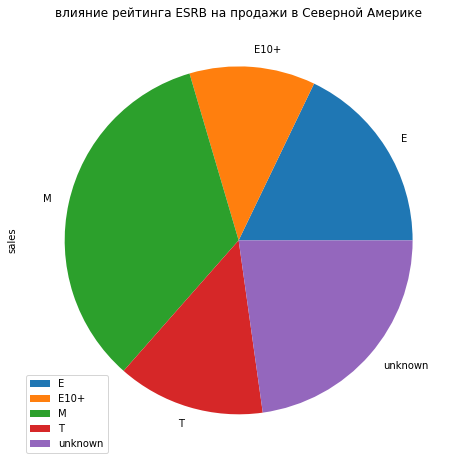

In [80]:
data.groupby('rating')\
.agg(sales=('na_sales', 'sum'))\
.plot(y = 'sales', kind = 'pie', figsize = (8,8),\
title = 'влияние рейтинга ESRB на продажи в Северной Америке')

<AxesSubplot:title={'center':'влияние рейтинга ESRB на продажи в Европе'}, ylabel='sales'>

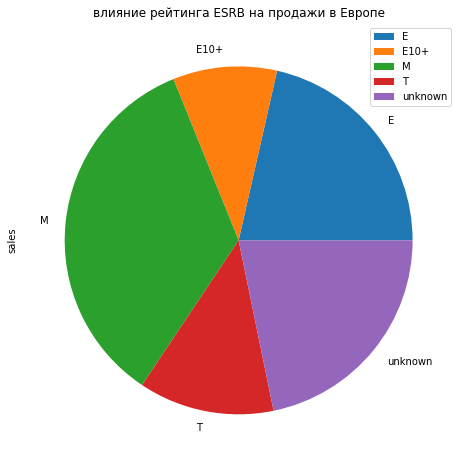

In [81]:
data.groupby('rating')\
.agg(sales=('eu_sales', 'sum'))\
.plot(y = 'sales', kind = 'pie', figsize = (8,8),\
title = 'влияние рейтинга ESRB на продажи в Европе')

<AxesSubplot:title={'center':'влияние рейтинга ESRB на продажи в Японии'}, ylabel='sales'>

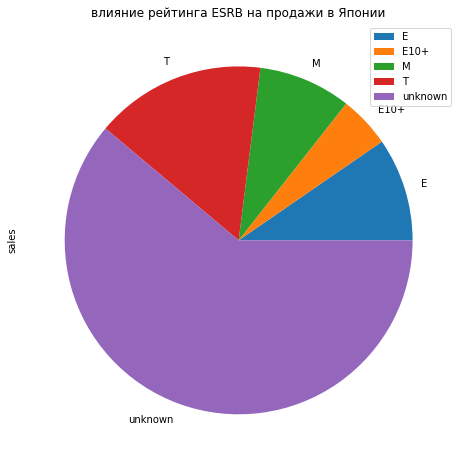

In [82]:
data.groupby('rating')\
.agg(sales=('jp_sales', 'sum'))\
.plot(y = 'sales', kind = 'pie', figsize = (8,8),\
title = 'влияние рейтинга ESRB на продажи в Японии')

## Проверка гипотез

### Гипотиза 1

Проверка гипотезы: cредние пользовательские рейтинги платформ Xbox One и PC одинаковые;

```
H_0: cредние пользовательские рейтинги платформ Xbox One и PC равны
H_1: cредние пользовательские рейтинги платформ Xbox One и PC не равны
alpha = 0.05
```

In [83]:
# results = вызов метода для проверки гипотезы
# alpha - значение уровня значимости


xone = data.query('platform == "XOne" and ~user_score.isna()')['user_score']
pc = data.query('platform == "PC" and ~user_score.isna()')['user_score']

results = st.ttest_ind(xone, pc, equal_var = False)

alpha = 0.05
# вывод значения p-value на экран 
print(results.pvalue)
# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
    


0.11601398086668832
Не получилось отвергнуть нулевую гипотезу


*Гипотеза о том, что средние пользовательские рейтинги платформ Xbox One и PC равны не была отвергнута*

### Гипотеза 2

Проверка гипотезы: Средние пользовательские рейтинги жанров Action и Sports разные;

```
H_0: Средние пользовательские рейтинги жанров Action и Sports не равны
H_1: Средние пользовательские рейтинги жанров Action и Sports равны
alpha = 0.05
```

In [84]:
# results = вызов метода для проверки гипотезы
# alpha - значение уровня значимости

action = data.query('genre == "Action" and ~user_score.isna()')['user_score']
sports = data.query('genre == "Sports" and ~user_score.isna()')['user_score']

results = st.ttest_ind(action, sports, equal_var = False)

alpha = 0.05
# вывод значения p-value на экран 
print(results.pvalue)
# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print('Не получилось отвергнуть нулевую гипотезу')    
else:
    print('Отвергаем нулевую гипотезу')

1.1825550382644557e-14
Не получилось отвергнуть нулевую гипотезу


*Гипотезу, что средние пользовательские рейтинги жанров Action и Sports разные не удалось отвергнуть*

## Общий вывод

- Меньше всего игр было с 1996-2000, после восходящий тренд, больше всего игр выпустилось в 2008-2009 годах, после количество выпускаемых игр идет на спад
- Больше всего продаж на платформах PS2, X360, PS3, Wii и DS
- На платформе PS2 пик продаж достигался в 2004 году, после идёт резкий спад
- На платформе X360 пик продаж достигался в 2010 году, после идёт резкий спад
- На платформе Wii пик продаж достигался в 2009 году, а на платформе PS3 в 2011
- На платформе DS пик продаж достигался в 2007-2008 годах
- PS были популярны до 2000 года, после появилось PS2 и стала лидировать по продажам
- С 2006-2007 года PS2 обогнали Wii, DS, X360 и PS3
- C 2014 года самой популярной является PS4
- Характерный срок жизни платформ топ-10: 7-10 лет 
- Будем считать актуальными данные с 2014 года
- Потенциально прибылиные платформы: PS4 и XOne,  они появились относительно недавно и являюся самыми популярными на 2016 год.При этом PS4 лидирут.
- Суммарные продажи растут с оцеками пользователей, связь не линейная.
- Суммарные продажи растут с оцеками критиков. 
- Самыми прибылиными являются жанры: Shooter, Sports, Platform, Fighting и Role-Playing
- Самыми низкоприбылиные жанры: Strategy, Puzzle, Adventure
- В Северной Америке топовыми являются платформы: X360, PS3, 3DS, PS4, XOne
- В Европе топовыми являются платформы: PS3, X360, XOne, PS4, 3DS
- В Японии топовыми являются платформы: PS4, 3DS, PS3, PSV, WiiU
- В Северной Америке топовыми являются жанры: Action, Shooter, Sports, Misc, Role-Playing
- В Европе топовыми являются жанры: Action, Shooter, Sports, Role-Playing, Racing
- В Японии топовыми являются жанры: Role-Playing, Action, Fighting, Misc, Shooter
- В Северной Америке и Европе лидируют рейтинги E, M, T. В Японии на первом месте неопределенный рейтинг, после идут также E, M, T. E - Для всех, M - Для взрослых, T -подростки. Причём в Японии игры для взрослых покупают реже, чем для тинейджеров. А в Северной Америке и Европе больше всего берут игры для всех и взрослых. Организация ESRB принадлежит США, так что с этим может быть связано так много unknown для Японцев.
- Гипотеза о том, что средние пользовательские рейтинги платформ Xbox One и PC равны не была отвергнута
- Гипотезу, что средние пользовательские рейтинги жанров Action и Sports разные не удалось отвергнуть